# Nam Tu - 153076622 - Locality-Sensitive Hashing (LSH)

# Task 2.1

### 1. Calculate the signature matrix by mapping hash values according to where a "1" appears in the original matrix. Put them all into a dataframe afterwards for easier visualization

In [1]:
import pandas as pd
import numpy as np

def h1(x):
    return (2*x+ 1)%6

def h2(x):
    return (3*x+2)%6

def h3(x):
    return (5*x+2)%6

#create the matrix
M = np.array([
    [1, 1, 0, 1],  
    [0, 1, 0, 0],  
    [0, 0, 0, 1], 
    [1, 0, 1, 0], 
    [0, 1, 1, 1], 
    [0, 0, 1, 0]  
])

#calculating the signature matrix
n_rows = M.shape[0]
columns = ["S1","S2","S3","S4"]
rows = ["h1","h2","h3"]
hash_functions = [h1,h2,h3]

signature_data = {}

for name, h in zip(rows, hash_functions):
    signature_row = []
    for j in range(len(columns)):
        rows_with_1 = np.where(M[:, j] == 1)[0]
        min_hash = min(h(r) for r in rows_with_1)
        signature_row.append(min_hash)
    signature_data[name] = signature_row

signature_df = pd.DataFrame(signature_data, index=columns).T

print("Signature Matrix:")
print(signature_df)

Signature Matrix:
    S1  S2  S3  S4
h1   1   1   1   1
h2   2   2   2   2
h3   2   1   3   0


### 2. Check if true permutation by checking if there are no repeats of the same value after calculating the hash value for all rows.

In [2]:
print("Permutation check:")
for name, h in zip(rows, hash_functions):
    values = [h(x) for x in range(n_rows)]
    is_perm = len(set(values)) == n_rows
    print(f"{name}: {values} -> Permutation? {is_perm}")
print()

Permutation check:
h1: [1, 3, 5, 1, 3, 5] -> Permutation? False
h2: [2, 5, 2, 5, 2, 5] -> Permutation? False
h3: [2, 1, 0, 5, 4, 3] -> Permutation? True



### 3. Write functions for both true and estimated Jaccard Similarities, and then print them pair-wise. As per their names, true Jaccard Similarity should reflect the similarites better, and this can be seen clearly. The similarities after hashing are almost all the same.

In [3]:
#Calculate true Jaccard similarity
def jaccard(col1, col2):
    set1 = set(np.where(M[:, col1] == 1)[0])
    set2 = set(np.where(M[:, col2] == 1)[0])
    return len(set1 & set2) / len(set1 | set2)

#Calculate estimated Jaccard similarity
def estimated_jaccard(c1, c2):
    matches = (signature_df.iloc[:, c1] == signature_df.iloc[:, c2]).sum()
    return matches / len(signature_df)

print("Pairwise Similarities:\n")
for c1 in range(len(columns)):
    for c2 in range(c1 + 1, len(columns)):

        true_sim = jaccard(c1, c2)
        est_sim = estimated_jaccard(c1, c2)

        print(f"{columns[c1]} vs {columns[c2]}")
        print(f"  True Jaccard      = {true_sim:.3f}")
        print(f"  Estimated Jaccard = {est_sim:.3f}\n")

Pairwise Similarities:

S1 vs S2
  True Jaccard      = 0.250
  Estimated Jaccard = 0.667

S1 vs S3
  True Jaccard      = 0.250
  Estimated Jaccard = 0.667

S1 vs S4
  True Jaccard      = 0.250
  Estimated Jaccard = 0.667

S2 vs S3
  True Jaccard      = 0.200
  Estimated Jaccard = 0.667

S2 vs S4
  True Jaccard      = 0.500
  Estimated Jaccard = 0.667

S3 vs S4
  True Jaccard      = 0.200
  Estimated Jaccard = 0.667



# Task 2.2

### 1. Plotting the curves

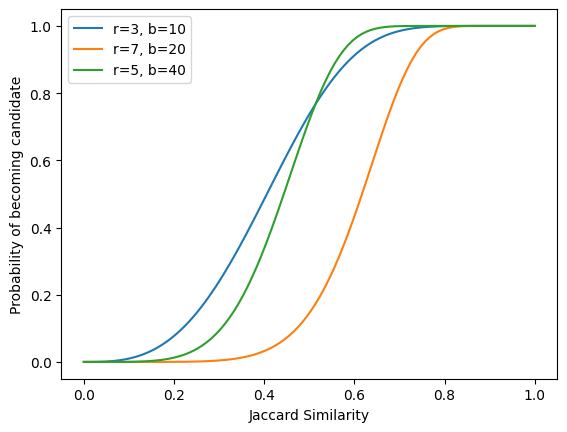

In [4]:
import matplotlib.pyplot as plt

rvals = [3,7,5]
bvals = [10,20,40]
s = np.linspace(0,1,100)

for r,b in zip(rvals,bvals):
    P = 1-(1-s**r)**b
    plt.plot(s, P,label=f"r={r}, b={b}")
    

plt.xlabel('Jaccard Similarity')
plt.ylabel('Probability of becoming candidate')
plt.legend()
plt.show()

### 2. Finding the values where P = 0.5 by finding the index of where P crosses the 0.5 threshold. Also calculate the estimate for comparison.


### The results are extremely similar, validating the fact that it is an estimate.

In [5]:
# Find value of Jaccard similarity for which the probability of becoming a candidate is 0.5
print("Values of Jaccard similarity (s) where P ≈ 0.5 for each (r, b):")
for r, b in zip(rvals, bvals):
    P = 1 - (1 - s**r)**b
    est = (1/b)**(1/r)
    # Find index where P crosses 0.5
    idx = np.argmin(np.abs(P - 0.5))
    print(f"  r={r}, b={b}: s ≈ {s[idx]:.3f}, estimate ≈ {est:.3f}")


Values of Jaccard similarity (s) where P ≈ 0.5 for each (r, b):
  r=3, b=10: s ≈ 0.404, estimate ≈ 0.464
  r=7, b=20: s ≈ 0.616, estimate ≈ 0.652
  r=5, b=40: s ≈ 0.444, estimate ≈ 0.478


# Task 2.3

## Task 2.3.1 Shingling

### According to the book, picking a k too small would make almost every document to seem similar to each other. "k should be picked large enough that the probability of any given shingle appearing in any given document is low"

### With the results of k = 3, one can see how many types of different words a single shingle can form, therefore not suitable for detecting similar documents

### A good rule of thumb is k = 5 for emails, k = 9 for large documents

In [23]:
import pyspark 
import re 
 
sc = pyspark.SparkContext("local", "Similarity") 
 
def make_shingles(text, shingle_len): 
    text = text.lower() 
    text = re.sub(r'[^a-z]+', '',text ) 
    for i in range( 0, len(text)-shingle_len-1 ): 
        yield text[i:i+shingle_len]   
 
shingle_length = 6         
         
files = sc.wholeTextFiles('./E2_Data/*.txt') 
files1 = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles( p[1], shingle_length) ) ) ) 
res = files1.collect() 

sample = files1.take(1)

for filename, shingles in sample:
    print("Shingle length 6:")
    print(filename)
    print(shingles[:5], "...")

shingle_length = 9        
         
files2 = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles( p[1], shingle_length) ) ) ) 
res = files2.collect() 
sample = files2.take(1)

for filename, shingles in sample:
    print("\nShingle length 9:")
    print(filename)
    print(shingles[:5], "...")

shingle_length = 3        
         
files3 = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles( p[1], shingle_length) ) ) ) 
res = files3.collect() 
sample = files3.take(1)

for filename, shingles in sample:
    print("\nShingle length 3:")
    print(filename)
    print(shingles[:5], "...")



Shingle length 6:
bank.txt
['abanki', 'bankis', 'ankisa', 'nkisaf', 'kisafi'] ...

Shingle length 9:
bank.txt
['abankisaf', 'bankisafi', 'ankisafin', 'nkisafina', 'kisafinan'] ...

Shingle length 3:
bank.txt
['aba', 'ban', 'ank', 'nki', 'kis'] ...


### Test with preserving white spaces

### It can be seen that preserving white space more than likely will cause documents to become even more likely, because every documents will have spaces in them (mostly), and taking white spaces into consideration will mean that the white spaces (and not the content alone) will skew the results.

In [24]:

def make_shingles(text, shingle_len): 
    text = text.lower() 
    text = re.sub(r'[^a-z]+\s+', '',text ) 
    for i in range( 0, len(text)-shingle_len-1 ): 
        yield text[i:i+shingle_len]   
 
shingle_length = 6         
         
files = sc.wholeTextFiles('./E2_Data/*.txt') 
files1 = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles( p[1], shingle_length) ) ) ) 
res = files1.collect() 

sample = files1.take(1)

for filename, shingles in sample:
    print("Shingle length 6:")
    print(filename)
    print(shingles[:5], "...")

shingle_length = 9        
         
files2 = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles( p[1], shingle_length) ) ) ) 
res = files2.collect() 
sample = files2.take(1)

for filename, shingles in sample:
    print("\nShingle length 9:")
    print(filename)
    print(shingles[:5], "...")

shingle_length = 3        
         
files3 = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles( p[1], shingle_length) ) ) ) 
res = files3.collect() 
sample = files3.take(1)

for filename, shingles in sample:
    print("\nShingle length 3:")
    print(filename)
    print(shingles[:5], "...")




Shingle length 6:
bank.txt
['a bank', ' bank ', 'bank i', 'ank is', 'nk is '] ...

Shingle length 9:
bank.txt
['a bank is', ' bank is ', 'bank is a', 'ank is a ', 'nk is a f'] ...

Shingle length 3:
bank.txt
['a b', ' ba', 'ban', 'ank', 'nk '] ...


## Task 2.3.2 Calculating hashes

### The code is hashing the usual shingles in ASCII letters into 32-bit integers hashes. Hashing compresses the data when the resulting hashes still has the same information but now in easier-to-work-with form (e.g. turning strings into 32-bit integers).

In [25]:
from numpy import uint32     
from numpy import uint64 
import random 
import numpy 
 
def generate_random_hash_params_A_P(): 
    A = random.getrandbits(64) 
    P = random.getrandbits(64) 
    while A>=P: 
        A = random.getrandbits(64) 
        P = random.getrandbits(64) 
    return A , P 
 
Ashingle, Pshingle = generate_random_hash_params_A_P() 
 
def string_hash(shingle,slen,A,P): 
    tmp = uint64(ord(shingle[0])) 
    for i in range(1, slen): 
        tmp = (tmp*uint64(A) + uint64(ord(shingle[i]))) % uint64(P) 
    return uint32(tmp&uint64(0xFFFFFFFF)) 

def make_shingles(text, shingle_len): 
    text = text.lower() 
    text = re.sub(r'[^a-z]+', '',text ) 
    for i in range( 0, len(text)-shingle_len-1 ): 
        yield string_hash(text[i:i+shingle_len],shingle_len, Ashingle, Pshingle)
 
shingle_length = 6         
         
files = sc.wholeTextFiles('./E2_Data/*.txt') 
files1 = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles( p[1], shingle_length) ) ) ) 
res = files1.collect() 
sample = files1.take(1)

for filename, shingles in sample:
    print("Shingle length 6:")
    print(filename)
    print(shingles[:5], "...")

shingle_length = 9        
         
files2 = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles( p[1], shingle_length) ) ) ) 
res = files2.collect() 
sample = files2.take(1)

for filename, shingles in sample:
    print("\nShingle length 9:")
    print(filename)
    print(shingles[:5], "...")

shingle_length = 3        
         
files3 = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles( p[1], shingle_length) ) ) ) 
res = files3.collect() 
sample = files3.take(1)

for filename, shingles in sample:
    print("\nShingle length 3:")
    print(filename)
    print(shingles[:5], "...")



sc.stop()

Shingle length 6:
bank.txt
[np.uint32(436660260), np.uint32(1596719775), np.uint32(2581751773), np.uint32(1459804333), np.uint32(2913866958)] ...

Shingle length 9:
bank.txt
[np.uint32(1077587182), np.uint32(3796041808), np.uint32(1825871139), np.uint32(989618755), np.uint32(1815414769)] ...

Shingle length 3:
bank.txt
[np.uint32(625486320), np.uint32(1919798747), np.uint32(2849391294), np.uint32(1390126676), np.uint32(2233985998)] ...


## Task 2.3.3

### The code produces the minhash signature matrix for every document. The documents now are each represented by 15 minhash numbers. (Printed results were way too long, limited to 5 files only and their 5 signature values)

In [31]:
from numpy import uint32     
from numpy import uint64 
import random 
import numpy 
 
import pyspark 
import re 
 
sc = pyspark.SparkContext("local", "Similarity") 
 
 
def generate_random_hash_params_A_P(): 
    A = random.getrandbits(64) 
    P = random.getrandbits(64) 
    while A>=P: 
        A = random.getrandbits(64) 
        P = random.getrandbits(64) 
    return A , P 
 
Ashingle, Pshingle = generate_random_hash_params_A_P() 
 
def string_hash(shingle,slen,A,P): 
    tmp = uint64(ord(shingle[0])) 
    for i in range(1, slen): 
        tmp = (tmp*uint64(A) + uint64(ord(shingle[i]))) % uint64(P) 
    return uint32(tmp&uint64(0xFFFFFFFF)) 

def make_shingles(text, shingle_len): 
    text = text.lower() 
    text = re.sub(r'[^a-z]+', '',text ) 
    for i in range( 0, len(text)-shingle_len-1 ): 
        yield string_hash(text[i:i+shingle_len],shingle_len, Ashingle, Pshingle)
 
shingle_length = 6         
         
files = sc.wholeTextFiles('./E2_Data/*.txt') 
files1 = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles( p[1], shingle_length) ) ) ) 
res = files1.collect() 

def uint32_hash(stringhashes,A): 
    for i in range(0, len(stringhashes)): 
        stringhashes[i] = uint32((uint64(A)*uint64(stringhashes[i])) >> uint64(32)) 
    return stringhashes 
 
def min_hash(hashes,minhash_A): 
    minhashes = [] 
    for i in range(0,len(minhash_A)): 
        minhashes.append(min(uint32_hash(hashes,minhash_A[i]))) 
    return minhashes 
 
 
num_minhashes = 15 
minhash_A = [] 
for i in range(0,num_minhashes): 
    minhash_A.append( random.getrandbits(64) ) 
    

minhashes1 = files1.map(lambda p: (p[0],min_hash(p[1],minhash_A))) 
minhashes1.cache() #cache result for performance 
 

sample = minhashes1.take(5)

for filename, signature in sample:
    print("File:", filename)
    print("First 5 minhash values:", signature[:5], "...")
    print()
        
    


File: bank.txt
First 5 minhash values: [np.uint32(53845), np.uint32(125334), np.uint32(94658), np.uint32(490632), np.uint32(150246)] ...

File: cat.txt
First 5 minhash values: [np.uint32(27048), np.uint32(103751), np.uint32(24815), np.uint32(54657), np.uint32(150246)] ...

File: catfood.txt
First 5 minhash values: [np.uint32(53845), np.uint32(21451), np.uint32(36572), np.uint32(474261), np.uint32(428511)] ...

File: hadoop.txt
First 5 minhash values: [np.uint32(217214), np.uint32(125334), np.uint32(178037), np.uint32(347545), np.uint32(150246)] ...

File: hares.txt
First 5 minhash values: [np.uint32(53845), np.uint32(1054949), np.uint32(179206), np.uint32(88730), np.uint32(150246)] ...



## Task 2.3.4 Jaccard Similarity

### Using the given formula, the corresponding number of minhashes for each error rate is:
### 0.3: 11;
### 0.2: 25;
### 0.1: 100;
### 0.05: 400;

### Looking at the pairs, the accuracies seem to "swing" alot going from the first to third number. While a pair might increase or decrease rapidly in accuracies, some pairs see only decrease or increase. Only settling at a number with higher precision at 400 minhashes 

In [19]:
from numpy import uint32     
from numpy import uint64 
import random 
import numpy 
 
import pyspark 
import re 
 
sc = pyspark.SparkContext("local", "Similarity") 
 
 
def generate_random_hash_params_A_P(): 
    A = random.getrandbits(64) 
    P = random.getrandbits(64) 
    while A>=P: 
        A = random.getrandbits(64) 
        P = random.getrandbits(64) 
    return A , P 
 
Ashingle, Pshingle = generate_random_hash_params_A_P() 
 
def string_hash(shingle,slen,A,P): 
    tmp = uint64(ord(shingle[0])) 
    for i in range(1, slen): 
        tmp = (tmp*uint64(A) + uint64(ord(shingle[i]))) % uint64(P) 
    return uint32(tmp&uint64(0xFFFFFFFF)) 

def make_shingles(text, shingle_len): 
    text = text.lower() 
    text = re.sub(r'[^a-z]+', '',text ) 
    for i in range( 0, len(text)-shingle_len-1 ): 
        yield string_hash(text[i:i+shingle_len],shingle_len, Ashingle, Pshingle)
 
shingle_length = 6         
         
files = sc.wholeTextFiles('./Jaccard_test/*.txt') 
files1 = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles( p[1], shingle_length) ) ) ) 
res = files1.collect() 

def uint32_hash(stringhashes,A): 
    for i in range(0, len(stringhashes)): 
        stringhashes[i] = uint32((uint64(A)*uint64(stringhashes[i])) >> uint64(32)) 
    return stringhashes 
 
def min_hash(hashes,minhash_A): 
    minhashes = [] 
    for i in range(0,len(minhash_A)): 
        minhashes.append(min(uint32_hash(hashes,minhash_A[i]))) 
    return minhashes 
 
 
for num_minhashes in [11, 25, 100, 400]:

    minhash_A = [random.getrandbits(64) for _ in range(num_minhashes)]

    minhashes1 = files1.map(lambda p: (p[0], min_hash(p[1], minhash_A)))
    res = minhashes1.collect()

    print("\nNumber of Minhashes:", num_minhashes)

    count = 0
    for i in range(len(res)):
        for j in range(i+1, len(res)):  # avoid duplicates & self comparison
            sim = sum(
                numpy.array(res[i][1]) == numpy.array(res[j][1])
            ) / num_minhashes

            print(res[i][0], "vs", res[j][0], "similarity:", sim*100, "%")

            count += 1
            if count == 5:
                break
        if count == 5:
            break
        




Number of Minhashes: 11
bank.txt vs cat.txt similarity: 0.0 %
bank.txt vs hadoop.txt similarity: 9.090909090909092 %
bank.txt vs minhash.txt similarity: 0.0 %
bank.txt vs turtles.txt similarity: 0.0 %
cat.txt vs hadoop.txt similarity: 0.0 %

Number of Minhashes: 25
bank.txt vs cat.txt similarity: 12.0 %
bank.txt vs hadoop.txt similarity: 8.0 %
bank.txt vs minhash.txt similarity: 0.0 %
bank.txt vs turtles.txt similarity: 4.0 %
cat.txt vs hadoop.txt similarity: 4.0 %

Number of Minhashes: 100
bank.txt vs cat.txt similarity: 8.0 %
bank.txt vs hadoop.txt similarity: 6.0 %
bank.txt vs minhash.txt similarity: 3.0 %
bank.txt vs turtles.txt similarity: 8.0 %
cat.txt vs hadoop.txt similarity: 5.0 %

Number of Minhashes: 400
bank.txt vs cat.txt similarity: 7.75 %
bank.txt vs hadoop.txt similarity: 6.25 %
bank.txt vs minhash.txt similarity: 3.5000000000000004 %
bank.txt vs turtles.txt similarity: 6.75 %
cat.txt vs hadoop.txt similarity: 7.5 %


## 50 minhashes with 2 different single lengths with spaces/no spaces

### Analysis: As predicted in the previous task, hashing with spaces brought the average similarity for a single file up. Also, a mere increase in 2 in terms of shingle length significantly reduces the similarities between 2 files. This was made clear in the book, having a small shingle length may increase the chances of 2 files being considered similar drastically.

### (Disclaimer: the code below was edited by ChatGPT because mine was getting a bit too lengthy)

In [22]:
def make_shingles(text, shingle_len, keep_spaces):
    text = text.lower()
    
    if keep_spaces:
        text = re.sub(r'[^a-z ]+', '', text)
    else:
        text = re.sub(r'[^a-z]+', '', text)

    for i in range(0, len(text) - shingle_len + 1):
        yield string_hash(text[i:i+shingle_len],
                          shingle_len,
                          Ashingle,
                          Pshingle)
        
num_minhashes = 50
minhash_A = [random.getrandbits(64) for _ in range(num_minhashes)]

shingle_lengths = [4, 6]
space_options = [False, True]

for shingle_length in shingle_lengths:
    for keep_spaces in space_options:

        print("\n----------------------------------------")
        print("Shingle Length:", shingle_length,
              "| Keep Spaces:", keep_spaces)
        print("----------------------------------------")

        files1 = files.map(lambda p:
            (p[0].split("/")[-1],
             list(make_shingles(p[1], shingle_length, keep_spaces)))
        )

        minhashes = files1.map(lambda p:
            (p[0], min_hash(p[1], minhash_A))
        )

        res = minhashes.collect()

        # Select first 5 document pairs (unique pairs)
        count = 0
        for i in range(len(res)):
            for j in range(i+1, len(res)):

                sim = sum(
                    numpy.array(res[i][1]) ==
                    numpy.array(res[j][1])
                ) / num_minhashes

                print(res[i][0].ljust(20),
                      "vs.",
                      res[j][0].ljust(20),
                      "similarity:",
                      round(sim * 100, 2), "%")

                count += 1
                if count == 5:
                    break
            if count == 5:
                break
            
sc.stop()


----------------------------------------
Shingle Length: 4 | Keep Spaces: False
----------------------------------------
bank.txt             vs. cat.txt              similarity: 36.0 %
bank.txt             vs. hadoop.txt           similarity: 28.0 %
bank.txt             vs. minhash.txt          similarity: 20.0 %
bank.txt             vs. turtles.txt          similarity: 28.0 %
cat.txt              vs. hadoop.txt           similarity: 24.0 %

----------------------------------------
Shingle Length: 4 | Keep Spaces: True
----------------------------------------
bank.txt             vs. cat.txt              similarity: 42.0 %
bank.txt             vs. hadoop.txt           similarity: 30.0 %
bank.txt             vs. minhash.txt          similarity: 24.0 %
bank.txt             vs. turtles.txt          similarity: 40.0 %
cat.txt              vs. hadoop.txt           similarity: 30.0 %

----------------------------------------
Shingle Length: 6 | Keep Spaces: False
--------------------------